# Assignment 02: Try a Neural Network (PyTorch)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


# Part A — Tensors and Autograd
## A1. Tensor Operations

In [2]:
a = torch.randn(3)
b = torch.randn(3, 4)
c = torch.randn(4, 3)

print('shapes:')
print('a:', a.shape)
print('b:', b.shape)
print('c:', c.shape)

# matrix multiply
print('\nb @ c:', (b @ c).shape)

# element-wise multiply
print('b * b:', (b * b).shape)

# broadcasting
print('b + a.unsqueeze(1):', (b + a.unsqueeze(1)).shape)

# view / reshape
t = torch.randn(3, 4)
print('\nt.view(12):', t.view(12).shape)
print('t.reshape(2, 6):', t.reshape(2, 6).shape)

# permute
img = torch.randn(3, 32, 32)  # C H W
print('\nimg permute (H W C):', img.permute(1, 2, 0).shape)

# flatten
x = torch.randn(8, 3, 32, 32)
print('x flatten:', x.flatten(1).shape)

shapes:
a: torch.Size([3])
b: torch.Size([3, 4])
c: torch.Size([4, 3])

b @ c: torch.Size([3, 3])
b * b: torch.Size([3, 4])
b + a.unsqueeze(1): torch.Size([3, 4])

t.view(12): torch.Size([12])
t.reshape(2, 6): torch.Size([2, 6])

img permute (H W C): torch.Size([32, 32, 3])
x flatten: torch.Size([8, 3072])


## A2. Autograd

y = (wx + b)^2

dy/dw = 2(wx+b)*x = 28

dy/db = 2(wx+b) = 14

dy/dx = 2(wx+b)*w = 42

In [3]:
xv, wv, bv = 2.0, 3.0, 1.0
u = wv * xv + bv  # = 7

print('by hand: dy/dw =', 2*u*xv, '  dy/db =', 2*u, '  dy/dx =', 2*u*wv)

x = torch.tensor(xv, requires_grad=True)
w = torch.tensor(wv, requires_grad=True)
b = torch.tensor(bv, requires_grad=True)

y = (w * x + b) ** 2
y.backward()

print('autograd: dy/dw =', w.grad.item(), '  dy/db =', b.grad.item(), '  dy/dx =', x.grad.item())

assert abs(w.grad.item() - 2*u*xv) < 1e-5
assert abs(b.grad.item() - 2*u) < 1e-5
assert abs(x.grad.item() - 2*u*wv) < 1e-5
print('gradients match!')

by hand: dy/dw = 28.0   dy/db = 14.0   dy/dx = 42.0
autograd: dy/dw = 28.0   dy/db = 14.0   dy/dx = 42.0
gradients match!


# Part B — CIFAR-10
## B1. Load Dataset

In [4]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

full_train = torchvision.datasets.CIFAR10('./data', train=True,  download=True, transform=transform)
test_set   = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_set, val_set = torch.utils.data.random_split(
    full_train, [45000, 5000],
    generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True,  num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_set,   batch_size=128, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=128, shuffle=False, num_workers=2)

classes = full_train.classes

print('Train:', len(train_set), ' Val:', len(val_set), ' Test:', len(test_set))
print('Classes:', classes)

imgs, lbls = next(iter(train_loader))
print('Batch shape:', imgs.shape, lbls.shape)

100%|██████████| 170M/170M [00:14<00:00, 12.2MB/s]


Train: 45000  Val: 5000  Test: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch shape: torch.Size([128, 3, 32, 32]) torch.Size([128])


## B2. Visualize

image shape: torch.Size([3, 32, 32]) | label: 6 -> frog


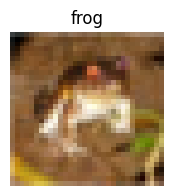

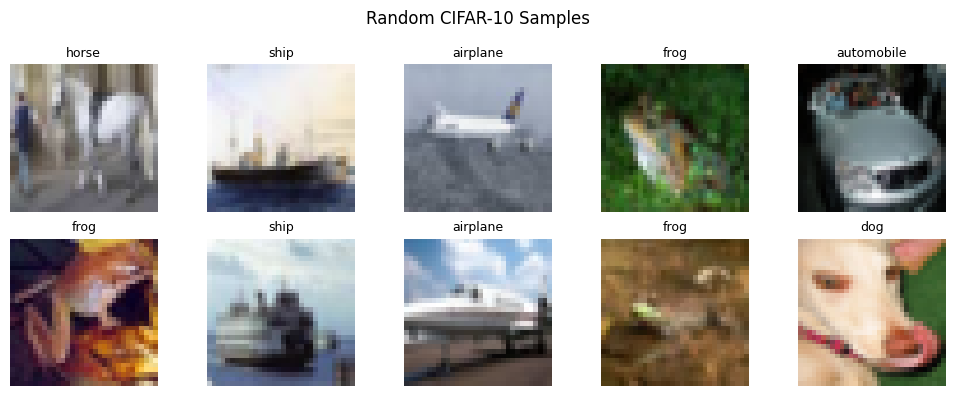

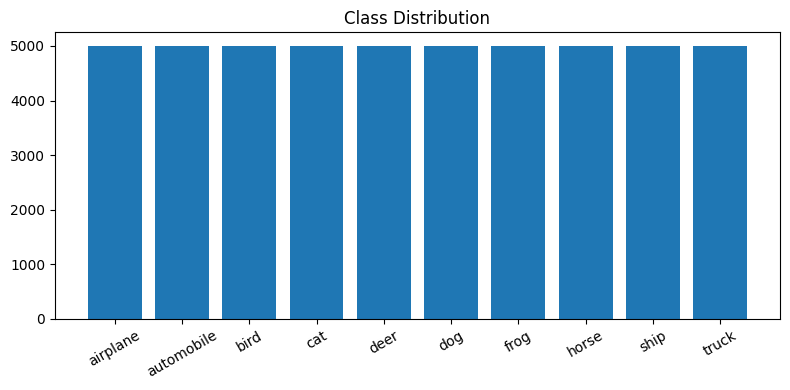

Dataset is balanced — 5000 images per class.


In [5]:
img, label = full_train[0]
print('image shape:', img.shape, '| label:', label, '->', classes[label])

def denorm(t):
    m = torch.tensor(mean).view(3, 1, 1)
    s = torch.tensor(std).view(3, 1, 1)
    return (t * s + m).clamp(0, 1).permute(1, 2, 0).numpy()

# show single image
plt.figure(figsize=(2, 2))
plt.imshow(denorm(img), interpolation='nearest')
plt.title(classes[label])
plt.axis('off')
plt.show()

# show 5x2 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, idx in zip(axes.flat, np.random.choice(len(full_train), 10, replace=False)):
    im, lb = full_train[idx]
    ax.imshow(denorm(im), interpolation='nearest')
    ax.set_title(classes[lb], fontsize=9)
    ax.axis('off')
plt.suptitle('Random CIFAR-10 Samples')
plt.tight_layout()
plt.show()

# class counts
counts = np.bincount(full_train.targets)
plt.figure(figsize=(8, 4))
plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print('Dataset is balanced — 5000 images per class.')

## B3. Preprocessing

**Mean:** (0.4914, 0.4822, 0.4465) — **Std:** (0.2470, 0.2435, 0.2616)

These are the standard CIFAR-10 per-channel statistics.

**Why normalization helps:** Without it, pixels range from 0 to 255 (or 0 to 1) which can make training slow and unstable. Normalization centers the data around zero with unit variance, so gradients are more consistent and the optimizer converges faster.

# Part C — MLP Model
## C1. Build the Model

In [6]:
class MLP(nn.Module):
    def __init__(self, hidden=[256, 128], dropout=0.0):
        super().__init__()
        layers = []
        in_dim = 3 * 32 * 32  # 3072
        for h in hidden:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 10))  # 10 classes, no softmax!
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.flatten(1)  # flatten image to vector
        return self.net(x)


model = MLP().to(device)
print(model)
print('Total params:', sum(p.numel() for p in model.parameters()))

MLP(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total params: 820874


## C2. Training Loop

In [7]:
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=20, optimizer_name='adam'):
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses = []
    train_accs   = []
    val_accs     = []

    best_val_acc = 0.0
    best_epoch   = 0
    best_state   = None
    start        = time.time()

    for epoch in range(1, epochs + 1):

        # --- train ---
        model.train()
        total_loss = 0.0
        correct    = 0
        total      = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct    += (outputs.argmax(1) == labels).sum().item()
            total      += images.size(0)

        train_losses.append(total_loss / total)
        train_accs.append(correct / total)

        # --- validate ---
        model.eval()
        correct = 0
        total   = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
                total   += images.size(0)

        val_acc = correct / total
        val_accs.append(val_acc)

        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch   = epoch
            best_state   = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch:2d} | loss {train_losses[-1]:.3f} | train acc {train_accs[-1]*100:.1f}% | val acc {val_acc*100:.1f}%')

    print(f'\nBest val acc: {best_val_acc*100:.2f}% at epoch {best_epoch}')
    print(f'Final val acc: {val_accs[-1]*100:.2f}%')
    print(f'Time: {time.time() - start:.0f}s')

    return train_losses, train_accs, val_accs, best_val_acc, val_accs[-1], best_epoch, best_state


def plot_curves(train_losses, train_accs, val_accs, title=''):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    axes[0].plot(epochs, train_losses)
    axes[0].set_title('Train Loss')
    axes[0].set_xlabel('Epoch')

    axes[1].plot(epochs, [a * 100 for a in train_accs])
    axes[1].set_title('Train Accuracy (%)')
    axes[1].set_xlabel('Epoch')

    axes[2].plot(epochs, [a * 100 for a in val_accs], color='orange')
    axes[2].set_title('Val Accuracy (%)')
    axes[2].set_xlabel('Epoch')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

=== Baseline: MLP [256, 128], Adam, lr=1e-3 ===
Epoch  1 | loss 1.659 | train acc 41.3% | val acc 45.8%
Epoch  5 | loss 1.180 | train acc 58.6% | val acc 51.2%
Epoch 10 | loss 0.877 | train acc 69.0% | val acc 53.0%
Epoch 15 | loss 0.649 | train acc 77.2% | val acc 52.3%
Epoch 20 | loss 0.484 | train acc 82.9% | val acc 51.4%

Best val acc: 53.34% at epoch 8
Final val acc: 51.36%
Time: 238s
Checkpoint saved, best epoch: 8


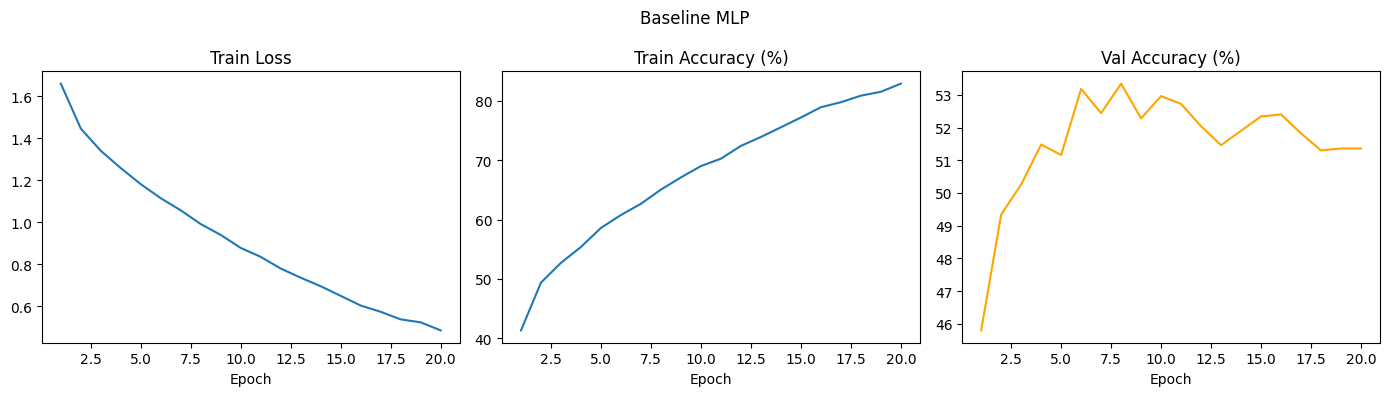

In [8]:
print('=== Baseline: MLP [256, 128], Adam, lr=1e-3 ===')
model = MLP().to(device)
tl, ta, va, best_acc, final_acc, best_ep, best_state = train_model(model, train_loader, val_loader)

torch.save(best_state, 'best_model.pth')
print('Checkpoint saved, best epoch:', best_ep)

plot_curves(tl, ta, va, 'Baseline MLP')

## C3. Parameters vs Hyperparameters

In [9]:
print('=== Learned Parameters ===')
for name, p in model.named_parameters():
    print(f'  {name}  shape={list(p.shape)}  count={p.numel()}')
print('Total parameters:', sum(p.numel() for p in model.parameters()))

print()
print('=== Hyperparameters (we chose these) ===')
print('  Learning rate :', '1e-3')
print('  Batch size    :', '128')
print('  Optimizer     :', 'Adam')
print('  Epochs        :', '20')
print('  Hidden sizes  :', '[256, 128]')
print('  Dropout       :', '0')

=== Learned Parameters ===
  net.0.weight  shape=[256, 3072]  count=786432
  net.0.bias  shape=[256]  count=256
  net.2.weight  shape=[128, 256]  count=32768
  net.2.bias  shape=[128]  count=128
  net.4.weight  shape=[10, 128]  count=1280
  net.4.bias  shape=[10]  count=10
Total parameters: 820874

=== Hyperparameters (we chose these) ===
  Learning rate : 1e-3
  Batch size    : 128
  Optimizer     : Adam
  Epochs        : 20
  Hidden sizes  : [256, 128]
  Dropout       : 0


# Part D — Experiments
## D1. Hyperparameter Experiments

In [ ]:
results = []
results.append(('Baseline lr=1e-3', best_acc, final_acc))

# D1a: smaller learning rate
print('=== lr = 3e-4 ===')
m = MLP().to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader, lr=3e-4)
results.append(('lr=3e-4', ba, fa))

# D1b: larger learning rate
print('\n=== lr = 3e-3 ===')
m = MLP().to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader, lr=3e-3)
results.append(('lr=3e-3', ba, fa))

=== lr = 3e-4 ===
Epoch  1 | loss 1.680 | train acc 40.7% | val acc 45.3%
Epoch  5 | loss 1.201 | train acc 58.4% | val acc 51.4%
Epoch 10 | loss 0.929 | train acc 68.0% | val acc 53.6%


In [ ]:
# D1c: smaller batch size
print('=== batch size 64 ===')
tl64 = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,  num_workers=2)
vl64 = torch.utils.data.DataLoader(val_set,   batch_size=64, shuffle=False, num_workers=2)
m = MLP().to(device)
_, _, _, ba, fa, _, _ = train_model(m, tl64, vl64)
results.append(('batch=64', ba, fa))

# D1d: SGD instead of Adam
print('\n=== SGD + momentum ===')
m = MLP().to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader, lr=1e-2, optimizer_name='sgd')
results.append(('SGD lr=1e-2', ba, fa))

# D1e: dropout
print('\n=== Dropout 0.3 ===')
m = MLP(dropout=0.3).to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader)
results.append(('Dropout=0.3', ba, fa))

## D2. Model Capacity Experiments

In [ ]:
# D2a: wider model
print('=== Wider MLP [1024, 512] ===')
m = MLP(hidden=[1024, 512]).to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader)
results.append(('Wide [1024,512]', ba, fa))

# D2b: deeper model
print('\n=== Deeper MLP [512, 256, 128, 64] ===')
m = MLP(hidden=[512, 256, 128, 64]).to(device)
_, _, _, ba, fa, _, _ = train_model(m, train_loader, val_loader)
results.append(('Deep [512,256,128,64]', ba, fa))

## D3. Results Table

In [ ]:
print(f"{'Run':<25} {'Best Val%':>10} {'Final Val%':>11}")
print('-' * 50)
for name, ba, fa in results:
    print(f'{name:<25} {ba*100:>10.2f} {fa*100:>11.2f}')

# bar chart
names     = [r[0] for r in results]
best_vals = [r[1] * 100 for r in results]

plt.figure(figsize=(8, 5))
plt.barh(names, best_vals)
plt.xlabel('Best Val Accuracy (%)')
plt.title('All Runs Comparison')
plt.tight_layout()
plt.show()

## D3. Analysis

**Which hyperparameter mattered most?**
The learning rate had the biggest effect. lr=3e-3 made training unstable with a very noisy loss. lr=3e-4 was too slow. The baseline lr=1e-3 worked best with Adam.

**Underfitting vs Overfitting:**
The baseline model shows slight overfitting — training accuracy keeps going up but validation accuracy flattens out after a few epochs. Adding dropout (0.3) helps close that gap. The SGD run converges slower and looks more like underfitting in the first epochs.